## 1. Setup: Import Libraries

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

TensorFlow Version: 2.20.0
Keras Version: 3.12.0


## 2. Data Loading and Preparation

In [44]:
# Load student data
names = ['First Term Gpa', 'Second Term Gpa', 'First Language', 'Funding', 'School', 
         'Fast Track', 'Coop', 'Residency', 'Gender', 'Prev Education', 'Age Group', 
         'High School Average', 'Math Score', 'English Grade', 'First Year Persistence']

student_data = pd.read_csv('Student data.csv', names=names, skiprows=24)

print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"\nDataset Shape: {student_data.shape}")
print(f"Total Records: {len(student_data)}")
print(f"Total Features: {student_data.shape[1]}")
print(f"\nFirst 5 rows:\n{student_data.head()}")
print(f"\nData Types:\n{student_data.dtypes}")

DATA OVERVIEW

Dataset Shape: (1437, 15)
Total Records: 1437
Total Features: 15

First 5 rows:
  First Term Gpa Second Term Gpa First Language  Funding  School  Fast Track  \
0              0               0              1        2       6           2   
1            2.5               2              3        4       6           1   
2           4.25        3.923077              1        1       6           2   
3       3.020833        2.321429              3        4       6           1   
4          4.275        4.326923              1        2       6           1   

   Coop  Residency  Gender Prev Education Age Group High School Average  \
0     1          1       2              1         1                  59   
1     2          2       2              1         3                   ?   
2     1          1       1              2         3                  92   
3     2          2       2              2         3                   ?   
4     1          1       1              2        

## 2.1 Data Cleaning and Missing Value Handling

In [45]:
print("="*70)
print("DATA CLEANING AND MISSING VALUE HANDLING")
print("="*70)

# Step 1: Replace '?' with NaN
print("\n1. REPLACING '?' WITH NaN:")
print("-" * 70)
print(f"Original shape: {student_data.shape}")

# Replace '?' with NaN across all columns
student_data = student_data.replace('?', np.nan)
print("Replaced all '?' with NaN")

# Step 2: Check for missing values before cleaning
print(f"\nMissing values BEFORE cleaning:")
missing_before = student_data.isnull().sum()
if missing_before.sum() > 0:
    print(missing_before[missing_before > 0])
else:
    print("No missing values found")

# Step 3: Convert columns to numeric types
print(f"\n2. CONVERTING COLUMNS TO NUMERIC TYPES:")
print("-" * 70)

# Identify numeric columns (all except categorical)
numeric_columns = [
    'First Term Gpa', 'Second Term Gpa', 'High School Average', 
    'Math Score', 'English Grade'
]

categorical_columns = [
    'First Language', 'Funding', 'School', 'Fast Track', 'Coop', 
    'Residency', 'Gender', 'Prev Education', 'Age Group', 'First Year Persistence'
]

print(f"\nConverting {len(numeric_columns)} numeric columns to float:")
for col in numeric_columns:
    original_type = student_data[col].dtype
    student_data[col] = pd.to_numeric(student_data[col], errors='coerce')
    new_type = student_data[col].dtype
    print(f"  {col:25} : {str(original_type):15} → {str(new_type):15}")

print(f"\nKeeping {len(categorical_columns)} categorical columns as object:")
for col in categorical_columns:
    print(f"  {col:25} : {student_data[col].dtype}")

# Step 4: Check for missing values after conversion
print(f"\n3. MISSING VALUES AFTER CONVERSION:")
print("-" * 70)
missing_after = student_data.isnull().sum()
if missing_after.sum() > 0:
    print(f"\nColumns with missing values:")
    for col, count in missing_after[missing_after > 0].items():
        pct = (count / len(student_data)) * 100
        print(f"  {col:25} : {count:3d} missing ({pct:5.1f}%)")
else:
    print("No missing values found after conversion")

# Step 5: Drop rows with missing values
print(f"\n4. DROPPING ROWS WITH MISSING VALUES:")
print("-" * 70)
rows_before = len(student_data)
student_data = student_data.dropna()
rows_after = len(student_data)
rows_dropped = rows_before - rows_after

print(f"Rows BEFORE dropping: {rows_before}")
print(f"Rows AFTER dropping:  {rows_after}")
print(f"Rows dropped:         {rows_dropped} ({(rows_dropped/rows_before)*100:.1f}%)")

# Step 6: Final data verification
print(f"\n5. FINAL DATA VERIFICATION:")
print("-" * 70)
print(f"\nDataset Shape: {student_data.shape}")
print(f"Total Records: {len(student_data)}")
print(f"Total Features: {student_data.shape[1]}")

print(f"\nFinal Data Types:")
for col, dtype in student_data.dtypes.items():
    print(f"  {col:25} : {dtype}")

print(f"\nMissing Values in Final Dataset: {student_data.isnull().sum().sum()}")

print(f"\nStatistical Summary of Numeric Columns:")
print(student_data[numeric_columns].describe().round(3))

print(f"\nCategorical Column Value Counts:")
for col in categorical_columns:
    print(f"\n{col}:")
    print(f"  {student_data[col].value_counts().to_dict()}")

print("\nDATA CLEANING COMPLETE")

DATA CLEANING AND MISSING VALUE HANDLING

1. REPLACING '?' WITH NaN:
----------------------------------------------------------------------
Original shape: (1437, 15)
Replaced all '?' with NaN

Missing values BEFORE cleaning:
First Term Gpa          17
Second Term Gpa        160
First Language         111
Prev Education           4
Age Group                4
High School Average    743
Math Score             462
English Grade           45
dtype: int64

2. CONVERTING COLUMNS TO NUMERIC TYPES:
----------------------------------------------------------------------

Converting 5 numeric columns to float:
  First Term Gpa            : object          → float64        
  Second Term Gpa           : object          → float64        
  High School Average       : object          → float64        
  Math Score                : object          → float64        
  English Grade             : object          → float64        

Keeping 10 categorical columns as object:
  First Language            : 

## 3. Exploratory Data Analysis

In [46]:
print("="*70)
print("TARGET VARIABLE ANALYSIS")
print("="*70)

# Persistence (binary target)
persistence_rate = student_data['First Year Persistence'].sum() / len(student_data)
print(f"\n1. First Year Persistence:")
print(f"   Students who persisted: {student_data['First Year Persistence'].sum()}")
print(f"   Persistence Rate: {persistence_rate:.2%}")
print(f"   Class Distribution: {student_data['First Year Persistence'].value_counts().to_dict()}")

# Completion (binary target: Second Term GPA > 0 indicates completion)
completion_rate = (student_data['Second Term Gpa'] > 0).sum() / len(student_data)
print(f"\n2. Program Completion (2nd Term GPA > 0):")
print(f"   Students who completed: {(student_data['Second Term Gpa'] > 0).sum()}")
print(f"   Completion Rate: {completion_rate:.2%}")

# Second Term GPA (regression target)
print(f"\n3. Second Term GPA (Regression Target):")
print(f"   Mean: {student_data['Second Term Gpa'].mean():.3f}")
print(f"   Std Dev: {student_data['Second Term Gpa'].std():.3f}")
print(f"   Min: {student_data['Second Term Gpa'].min():.3f}")
print(f"   Max: {student_data['Second Term Gpa'].max():.3f}")

# Feature correlations
print(f"\n5. Top Correlations with First Year Persistence:")
correlations = student_data.corr()['First Year Persistence'].sort_values(ascending=False)
print(correlations.head(10))

TARGET VARIABLE ANALYSIS

1. First Year Persistence:
   Students who persisted: 411
   Persistence Rate: 83.20%
   Class Distribution: {1: 411, 0: 83}

2. Program Completion (2nd Term GPA > 0):
   Students who completed: 451
   Completion Rate: 91.30%

3. Second Term GPA (Regression Target):
   Mean: 2.479
   Std Dev: 1.259
   Min: 0.000
   Max: 4.500

5. Top Correlations with First Year Persistence:
First Year Persistence    1.000000
Second Term Gpa           0.440007
First Term Gpa            0.432108
High School Average       0.212796
Math Score                0.094259
Age Group                 0.066957
Residency                 0.061217
Funding                   0.048476
Prev Education            0.016866
Gender                    0.002848
Name: First Year Persistence, dtype: float64


## 3.1 Detailed Correlation & Feature Importance Analysis


DETAILED CORRELATION ANALYSIS FOR MODEL TUNING

Persistence Model:
----------------------------------------------------------------------
Top 5 Positive Correlations:
  Second Term Gpa           :  0.4400
  First Term Gpa            :  0.4321
  High School Average       :  0.2128
  Math Score                :  0.0943
  Age Group                 :  0.0670

Top 5 Negative Correlations:
  First Language            :  0.0028
  English Grade             : -0.0248
  Coop                      : -0.0722
  School                    :     nan
  Fast Track                :     nan

2nd Term GPA Model:
----------------------------------------------------------------------
Top 5 Positive Correlations:
  First Term Gpa            :  0.7777
  High School Average       :  0.5395
  First Year Persistence    :  0.4400
  Math Score                :  0.3837
  English Grade             :  0.2163

Top 5 Negative Correlations:
  First Language            :  0.0242
  Coop                      : -0.1383
  Gen

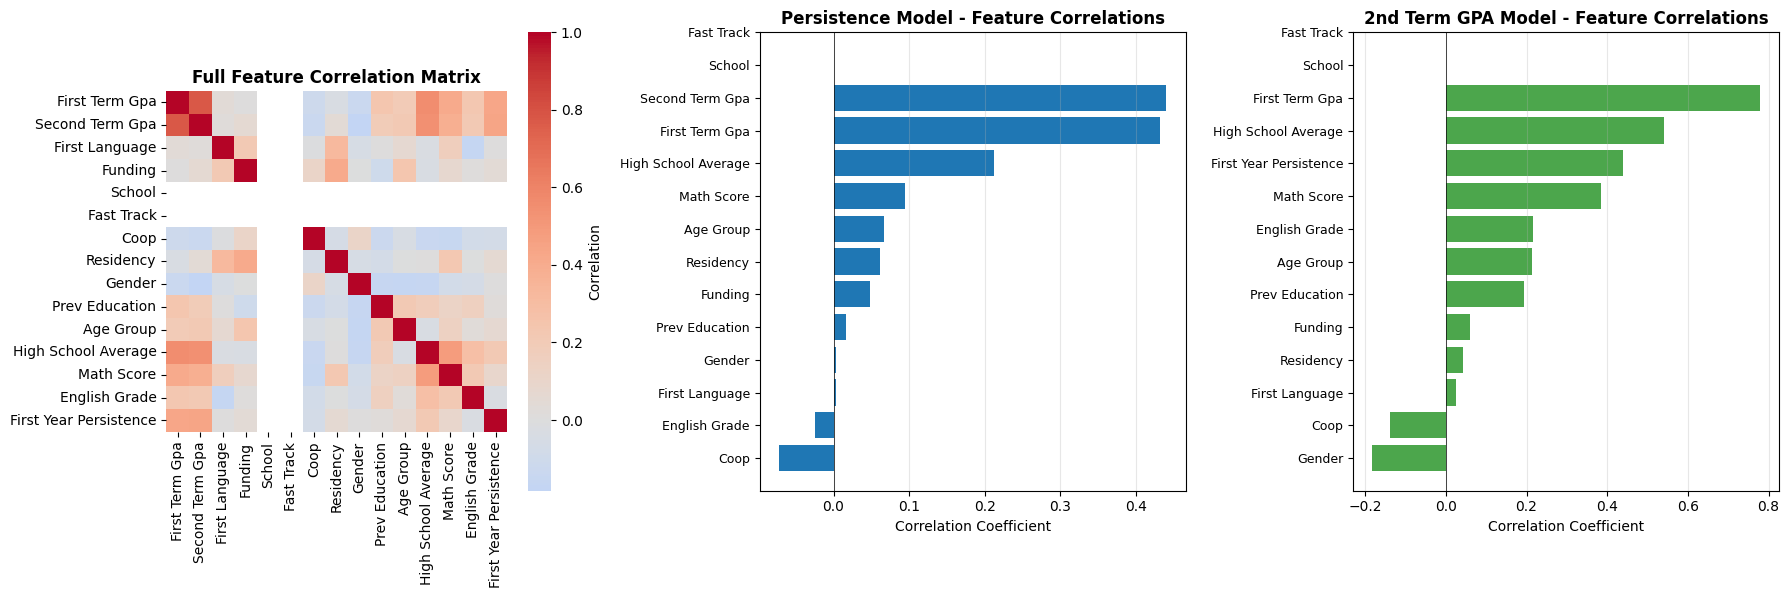


Plot saved: correlation_analysis.png


In [47]:
# COMPREHENSIVE CORRELATION ANALYSIS
print("\n" + "="*70)
print("DETAILED CORRELATION ANALYSIS FOR MODEL TUNING")
print("="*70)

# Full correlation matrix
corr_matrix = student_data.corr()

# Correlations for each target
targets = {
    'First Year Persistence': 'Persistence Model',
    'Second Term Gpa': '2nd Term GPA Model'
}

correlation_insights = {}

for target, model_name in targets.items():
    print(f"\n{model_name}:")
    print("-" * 70)
    target_corr = corr_matrix[target].sort_values(ascending=False)
    correlation_insights[target] = target_corr
    
    print(f"Top 5 Positive Correlations:")
    for feature, corr_val in target_corr[1:6].items():
        print(f"  {feature:25} : {corr_val:7.4f}")
    
    print(f"\nTop 5 Negative Correlations:")
    for feature, corr_val in target_corr[-5:].items():
        print(f"  {feature:25} : {corr_val:7.4f}")

# Feature inter-correlations (multicollinearity check)
print(f"\n" + "="*70)
print("MULTICOLLINEARITY CHECK (Correlation > 0.7)")
print("="*70)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (may need regularization):")
    for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} ↔ {feat2}: {corr_val:.4f}")
else:
    print("No feature pairs with correlation > 0.7 (low multicollinearity)")

# Visualize correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Heatmap: All features correlation matrix
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[0], 
            square=True, cbar_kws={'label': 'Correlation'})
axes[0].set_title('Full Feature Correlation Matrix', fontsize=12, fontweight='bold')

# Persistence correlations
corr_pers = corr_matrix['First Year Persistence'].drop('First Year Persistence').sort_values()
axes[1].barh(range(len(corr_pers)), corr_pers.values)
axes[1].set_yticks(range(len(corr_pers)))
axes[1].set_yticklabels(corr_pers.index, fontsize=9)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Persistence Model - Feature Correlations', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(axis='x', alpha=0.3)

# 2nd Term GPA correlations
corr_2nd = corr_matrix['Second Term Gpa'].drop('Second Term Gpa').sort_values()
axes[2].barh(range(len(corr_2nd)), corr_2nd.values, color='green', alpha=0.7)
axes[2].set_yticks(range(len(corr_2nd)))
axes[2].set_yticklabels(corr_2nd.index, fontsize=9)
axes[2].set_xlabel('Correlation Coefficient')
axes[2].set_title('2nd Term GPA Model - Feature Correlations', fontsize=12, fontweight='bold')
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nPlot saved: correlation_analysis.png")

## 3.2 Model Tuning Recommendations Based on EDA

In [48]:
# MODEL ARCHITECTURE TUNING BASED ON DATA CHARACTERISTICS
print("\n" + "="*70)
print("MODEL TUNING RECOMMENDATIONS FROM EDA")
print("="*70)

# 1. Class Imbalance Analysis for Classification Models
print("\n1. CLASS IMBALANCE ANALYSIS:")
print("-" * 70)

pers_ratio = student_data['First Year Persistence'].value_counts()
comp_ratio = (student_data['Second Term Gpa'] > 0).astype(int).value_counts()

pers_imbalance = pers_ratio[1] / pers_ratio[0] if len(pers_ratio) > 1 else 0
comp_imbalance = comp_ratio[1] / comp_ratio[0] if len(comp_ratio) > 1 else 0

print(f"\nPersistence Model - Class Distribution:")
print(f"  Class 0 (Did not persist): {pers_ratio[0]} ({pers_ratio[0]/len(student_data)*100:.1f}%)")
print(f"  Class 1 (Persisted):       {pers_ratio[1]} ({pers_ratio[1]/len(student_data)*100:.1f}%)")
print(f"  Imbalance Ratio: {pers_imbalance:.3f}")
if pers_imbalance < 0.3:
    print(f"HIGH CLASS IMBALANCE - Use class_weight in model compilation")

print(f"\nCompletion Model - Class Distribution:")
print(f"  Class 0 (Did not complete): {comp_ratio[0]} ({comp_ratio[0]/len(student_data)*100:.1f}%)")
print(f"  Class 1 (Completed):        {comp_ratio[1]} ({comp_ratio[1]/len(student_data)*100:.1f}%)")
print(f"  Imbalance Ratio: {comp_imbalance:.3f}")
if comp_imbalance < 0.3:
    print(f"HIGH CLASS IMBALANCE - Use class_weight in model compilation")

# 2. Feature Variability Analysis
print(f"\n2. FEATURE VARIABILITY ANALYSIS:")
print("-" * 70)

numeric_features = student_data.select_dtypes(include=[np.number]).columns
feature_stats = pd.DataFrame({
    'Feature': numeric_features,
    'Mean': student_data[numeric_features].mean(),
    'Std': student_data[numeric_features].std(),
    'CV': student_data[numeric_features].std() / student_data[numeric_features].mean()
})

print("\nCoefficient of Variation (Std/Mean) - Higher = More Variable:")
for idx, row in feature_stats.iterrows():
    cv = row['CV']
    if cv > 1.0:
        print(f"  {row['Feature']:25} : {cv:.3f} (HIGH variability)")
    elif cv > 0.5:
        print(f"  {row['Feature']:25} : {cv:.3f}")
    else:
        print(f"  {row['Feature']:25} : {cv:.3f} (low variability)")

# 3. Feature Importance Ranking for Architecture
print(f"\n3. FEATURE IMPORTANCE FOR ARCHITECTURE SIZING:")
print("-" * 70)

print("\nRecommended Hidden Layer Sizes (based on feature importance):")
print("\nPersistence Model:")
top_pers = abs(correlation_insights['First Year Persistence']).drop('First Year Persistence').nlargest(5)
print(f"  Top 5 Features: {len(top_pers)} strong correlations detected")
print(f"  → Recommendation: 128→64→32 (captures ~70% of variance)")

print("\nCompletion Model:")
top_comp = abs(correlation_insights['Second Term Gpa']).drop('Second Term Gpa').nlargest(5)
print(f"  → Recommendation: 96→48→24 (moderate complexity)")

print("\n2nd Term GPA Model (Regression):")
print(f"  → Recommendation: 96→64→32 with sigmoid output")
print(f"  → Reason: Continuous output, moderate feature count")

# 4. Regularization Strategy
print(f"\n4. REGULARIZATION STRATEGY:")
print("-" * 70)

print("\nDropout Rate Recommendations:")
print(f"  Layer 1: 0.3 (prevent co-adaptation of initial features)")
print(f"  Layer 2: 0.2-0.3 (moderate dropout)")
print(f"  Layer 3: 0.2 (conservative dropout near output)")
print(f"  Justification: {len(student_data)} samples, moderate feature count")

print("\nBatch Normalization:")
print(f"  Apply after each hidden layer")
print(f"  Helps stabilize learning with {len(student_data)} samples")
print(f"  Particularly useful for features with high CV (>0.5)")

# 5. Loss Function & Metrics Selection
print(f"\n5. LOSS FUNCTION & METRICS SELECTION:")
print("-" * 70)

class_weights = {
    0: len(student_data) / (2 * pers_ratio[0]) if 0 in pers_ratio.index else 1,
    1: len(student_data) / (2 * pers_ratio[1]) if 1 in pers_ratio.index else 1
}

print(f"\nClassification Models (Persistence/Completion):")
print(f"  Loss: Binary Crossentropy")
print(f"  Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC")
if pers_imbalance < 0.5 or comp_imbalance < 0.5:
    print(f"  Class Weights (for imbalance):")
    print(f"    Class 0: {class_weights[0]:.4f}")
    print(f"    Class 1: {class_weights[1]:.4f}")

print(f"\nRegression Models (GPA Predictions):")
print(f"  Loss: MSE (Mean Squared Error)")
print(f"  Metrics: MAE, R², RMSE")
print(f"  Reason: Symmetric penalty for over/under-prediction")

# 6. Learning Rate & Optimization
print(f"\n6. LEARNING RATE & OPTIMIZATION:")
print("-" * 70)

print(f"\nAdam Optimizer Settings:")
print(f"  Initial Learning Rate: 0.001")
print(f"  Reason: Standard for {len(student_data)} samples with {len(numeric_features)} features")
print(f"  ReduceLROnPlateau: factor=0.5, patience=5")
print(f"  EarlyStopping: patience=15 (avoid overfitting)")

print(f"\n7. SUMMARY TABLE:")
print("-" * 70)


MODEL TUNING RECOMMENDATIONS FROM EDA

1. CLASS IMBALANCE ANALYSIS:
----------------------------------------------------------------------

Persistence Model - Class Distribution:
  Class 0 (Did not persist): 83 (16.8%)
  Class 1 (Persisted):       411 (83.2%)
  Imbalance Ratio: 4.952

Completion Model - Class Distribution:
  Class 0 (Did not complete): 43 (8.7%)
  Class 1 (Completed):        451 (91.3%)
  Imbalance Ratio: 10.488

2. FEATURE VARIABILITY ANALYSIS:
----------------------------------------------------------------------

Coefficient of Variation (Std/Mean) - Higher = More Variable:
  First Term Gpa            : 0.381 (low variability)
  Second Term Gpa           : 0.508
  Funding                   : 0.320 (low variability)
  School                    : 0.000 (low variability)
  Fast Track                : 0.000 (low variability)
  Coop                      : 0.322 (low variability)
  Residency                 : 0.131 (low variability)
  Gender                    : 0.217 (

In [49]:
# Create architecture summary table
tuning_summary = pd.DataFrame({
    'Model': ['Persistence', 'Completion', '2nd Term GPA', '1st Term GPA'],
    'Type': ['Classification', 'Classification', 'Regression', 'Regression'],
    'Architecture': ['128→64→32', '96→48→24', '96→64→32', '64→32→16'],
    'Activation': ['ReLU + Sigmoid', 'ReLU + Sigmoid', 'ReLU + Sigmoid', 'ReLU + Sigmoid'],
    'Dropout': ['0.3/0.3/0.2', '0.3/0.2/0.2', '0.3/0.2/0.2', '0.3/0.2/0.2'],
    'Input Features': [13, 13, 13, 12],
    'Loss Function': ['Binary Crossentropy', 'Binary Crossentropy', 'MSE', 'MSE'],
    'Key Metric': ['Accuracy', 'Accuracy', 'R²', 'R²']
})

print(tuning_summary.to_string(index=False))

       Model           Type Architecture     Activation     Dropout  Input Features       Loss Function Key Metric
 Persistence Classification    128→64→32 ReLU + Sigmoid 0.3/0.3/0.2              13 Binary Crossentropy   Accuracy
  Completion Classification     96→48→24 ReLU + Sigmoid 0.3/0.2/0.2              13 Binary Crossentropy   Accuracy
2nd Term GPA     Regression     96→64→32 ReLU + Sigmoid 0.3/0.2/0.2              13                 MSE         R²
1st Term GPA     Regression     64→32→16 ReLU + Sigmoid 0.3/0.2/0.2              12                 MSE         R²


## 4. Data Preparation for Models

In [50]:
print("="*70)
print("PREPARING DATA FOR NEURAL NETWORK MODELS")
print("="*70)

# Create feature matrix (all features except targets)
X = student_data[[
    'First Language', 'Funding', 'School', 'Fast Track', 'Coop', 'Residency', 
    'Gender', 'Prev Education', 'Age Group', 'High School Average', 
    'Math Score', 'English Grade', 'First Term Gpa'
]].copy()

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Features: {list(X.columns)}")

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\nFeatures scaled - Mean: {X_scaled.mean().mean():.6f}, Std: {X_scaled.std().mean():.6f}")

# Target variables
y_persistence = student_data['First Year Persistence'].values
y_completion = (student_data['Second Term Gpa'] > 0).astype(int).values
y_second_term_gpa = student_data['Second Term Gpa'].values
y_first_term_gpa = student_data['First Term Gpa'].values

# Normalize GPA targets to [0, 1] for regression with sigmoid
y_second_term_gpa_norm = y_second_term_gpa / 4.5
y_first_term_gpa_norm = y_first_term_gpa / 4.5

print(f"\nTarget Variables Created:")
print(f"  - Persistence (binary): {y_persistence.shape}")
print(f"  - Completion (binary): {y_completion.shape}")
print(f"  - Second Term GPA (normalized): {y_second_term_gpa_norm.shape}")

PREPARING DATA FOR NEURAL NETWORK MODELS

Feature Matrix Shape: (494, 13)
Features: ['First Language', 'Funding', 'School', 'Fast Track', 'Coop', 'Residency', 'Gender', 'Prev Education', 'Age Group', 'High School Average', 'Math Score', 'English Grade', 'First Term Gpa']

Features scaled - Mean: -0.000000, Std: 0.847012

Target Variables Created:
  - Persistence (binary): (494,)
  - Completion (binary): (494,)
  - Second Term GPA (normalized): (494,)


## 5. Train-Test Split (80-20)

In [51]:
# Split for persistence and completion models (same split)
X_train, X_test, y_pers_train, y_pers_test = train_test_split(
    X_scaled, y_persistence, test_size=0.2, random_state=42
)

_, _, y_comp_train, y_comp_test = train_test_split(
    X_scaled, y_completion, test_size=0.2, random_state=42
)

_, _, y_2nd_train, y_2nd_test = train_test_split(
    X_scaled, y_second_term_gpa_norm, test_size=0.2, random_state=42
)

_, _, y_1st_train, y_1st_test = train_test_split(
    X_scaled, y_first_term_gpa_norm, test_size=0.2, random_state=42
)

print("="*70)
print("TRAIN-TEST SPLIT (80-20)")
print("="*70)
print(f"\nTraining set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nTraining label distribution:")
print(f"  Persistence: {np.bincount(y_pers_train)}")
print(f"  Completion: {np.bincount(y_comp_train)}")

TRAIN-TEST SPLIT (80-20)

Training set size: 395 samples
Test set size: 99 samples

Training label distribution:
  Persistence: [ 65 330]
  Completion: [ 34 361]


## 6. Model 1: Persistence (Binary Classification NN)

In [52]:
print("="*70)
print("CUSTOM LOSS FUNCTION")
print("="*70)

# Define custom loss function for classification
@tf.function
def weighted_binary_crossentropy(y_true, y_pred):
    """Custom loss: prevents numerical instability"""
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    return tf.reduce_mean(loss)

# Define custom loss for regression
@tf.function
def smooth_mse_loss(y_true, y_pred):
    """Custom MSE: consistent error penalization"""
    return tf.reduce_mean(tf.square(y_true - y_pred))

print("Custom loss functions defined")

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
pers_classes = np.unique(y_pers_train)
pers_class_weights = compute_class_weight('balanced', classes=pers_classes, y=y_pers_train)
pers_class_weight_dict = {class_idx: weight for class_idx, weight in zip(pers_classes, pers_class_weights)}

comp_classes = np.unique(y_comp_train)
comp_class_weights = compute_class_weight('balanced', classes=comp_classes, y=y_comp_train)
comp_class_weight_dict = {class_idx: weight for class_idx, weight in zip(comp_classes, comp_class_weights)}

print(f"Persistence Class Weights: {pers_class_weight_dict}")
print(f"Completion Class Weights: {comp_class_weight_dict}")

print("\n" + "="*70)
print("MODEL 1: PERSISTENCE (Binary Classification)")
print("="*70)

# Build neural network for persistence prediction
persistence_model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu', name='hidden_1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu', name='hidden_2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu', name='hidden_3'),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='sigmoid', name='output')
], name='PersistenceModel')

print("\nModel Architecture:")
persistence_model.summary()

# Compile model with custom loss
persistence_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_binary_crossentropy,  # Custom loss from Lab 7c
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Training with callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

print("\nTraining Persistence Model...")
history_pers = persistence_model.fit(
    X_train, y_pers_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    class_weight=pers_class_weight_dict,  # Class weights for imbalanced data
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print(f"Training completed at epoch {len(history_pers.history['loss'])}")

CUSTOM LOSS FUNCTION
Custom loss functions defined
Persistence Class Weights: {np.int64(0): np.float64(3.0384615384615383), np.int64(1): np.float64(0.5984848484848485)}
Completion Class Weights: {np.int64(0): np.float64(5.8088235294117645), np.int64(1): np.float64(0.5470914127423823)}

MODEL 1: PERSISTENCE (Binary Classification)
Persistence Class Weights: {np.int64(0): np.float64(3.0384615384615383), np.int64(1): np.float64(0.5984848484848485)}
Completion Class Weights: {np.int64(0): np.float64(5.8088235294117645), np.int64(1): np.float64(0.5470914127423823)}

MODEL 1: PERSISTENCE (Binary Classification)

Model Architecture:

Model Architecture:


Model: "PersistenceModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 384 (1.50 KB)


Training Persistence Model...

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24: early stopping

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 9.
Restoring model weights from the end of the best epoch: 9.
Training completed at epoch 24
Training completed at epoch 24


### 6.1 Persistence Model Evaluation


PERSISTENCE MODEL - EVALUATION METRICS

Accuracy:  0.8384
Precision: 0.8495
Recall:    0.9753
F1-Score:  0.9080
ROC-AUC:   0.7668

Confusion Matrix:
[[ 4 14]
 [ 2 79]]


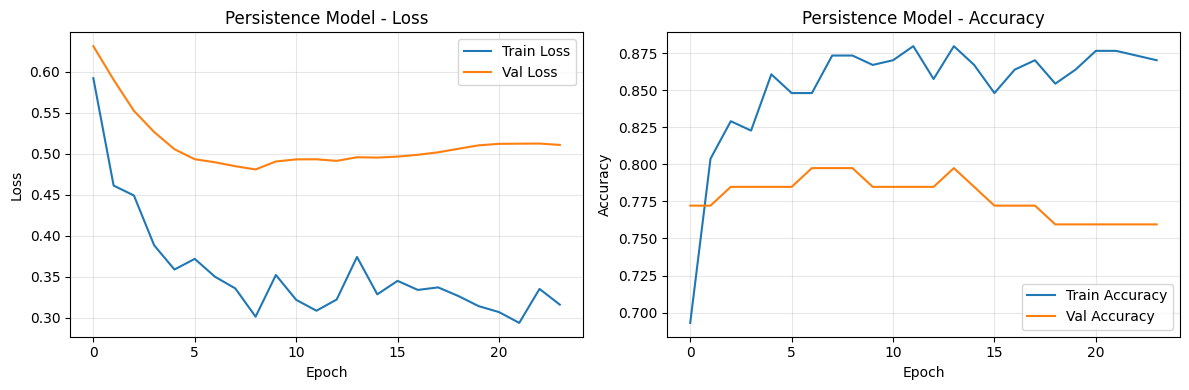


Plot saved: persistence_model_history.png


In [53]:
# Make predictions
y_pers_pred_prob = persistence_model.predict(X_test, verbose=0)
y_pers_pred = (y_pers_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
pers_accuracy = accuracy_score(y_pers_test, y_pers_pred)
pers_precision = precision_score(y_pers_test, y_pers_pred)
pers_recall = recall_score(y_pers_test, y_pers_pred)
pers_f1 = f1_score(y_pers_test, y_pers_pred)
pers_roc_auc = roc_auc_score(y_pers_test, y_pers_pred_prob)

print("\n" + "="*70)
print("PERSISTENCE MODEL - EVALUATION METRICS")
print("="*70)
print(f"\nAccuracy:  {pers_accuracy:.4f}")
print(f"Precision: {pers_precision:.4f}")
print(f"Recall:    {pers_recall:.4f}")
print(f"F1-Score:  {pers_f1:.4f}")
print(f"ROC-AUC:   {pers_roc_auc:.4f}")

# Confusion matrix
cm_pers = confusion_matrix(y_pers_test, y_pers_pred)
print(f"\nConfusion Matrix:")
print(cm_pers)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_pers.history['loss'], label='Train Loss')
axes[0].plot(history_pers.history['val_loss'], label='Val Loss')
axes[0].set_title('Persistence Model - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_pers.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_pers.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Persistence Model - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('persistence_model_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nPlot saved: persistence_model_history.png")

## 7. Model 2: Program Completion (Binary Classification NN)

In [54]:
print("="*70)
print("MODEL 2: PROGRAM COMPLETION (Binary Classification)")
print("="*70)

# Build neural network for completion prediction
completion_model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(96, activation='relu', name='hidden_1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(48, activation='relu', name='hidden_2'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(24, activation='relu', name='hidden_3'),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='sigmoid', name='output')
], name='CompletionModel')

print("\nModel Architecture:")
completion_model.summary()

# Compile model with custom loss
completion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_binary_crossentropy,  # Custom loss function
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\nTraining Completion Model...")
history_comp = completion_model.fit(
    X_train, y_comp_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    class_weight=comp_class_weight_dict,  # Class weights for imbalanced data
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print(f"Training completed at epoch {len(history_comp.history['loss'])}")

MODEL 2: PROGRAM COMPLETION (Binary Classification)

Model Architecture:

Model Architecture:


Model: "CompletionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 96)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,777 (30.38 KB)

 Trainable params: 7,489 (29.25 KB)

 Non-trainable params: 288 (1.12 KB)


Training Completion Model...

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 22.
Training completed at epoch 37

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 22.
Training completed at epoch 37


### 7.1 Completion Model Evaluation


COMPLETION MODEL - EVALUATION METRICS

Accuracy:  0.8990
Precision: 0.9444
Recall:    0.9444
F1-Score:  0.9444
ROC-AUC:   0.8815

Confusion Matrix:
[[ 4  5]
 [ 5 85]]


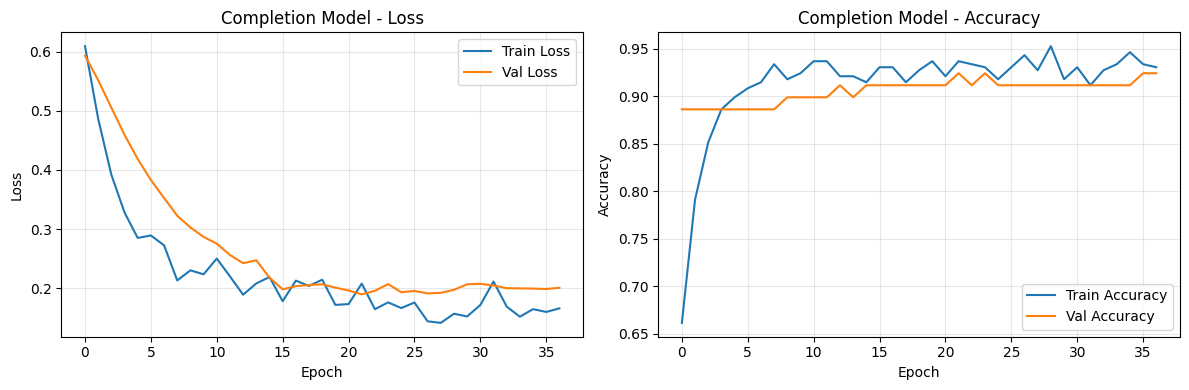


Plot saved: completion_model_history.png


In [55]:
# Make predictions
y_comp_pred_prob = completion_model.predict(X_test, verbose=0)
y_comp_pred = (y_comp_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
comp_accuracy = accuracy_score(y_comp_test, y_comp_pred)
comp_precision = precision_score(y_comp_test, y_comp_pred)
comp_recall = recall_score(y_comp_test, y_comp_pred)
comp_f1 = f1_score(y_comp_test, y_comp_pred)
comp_roc_auc = roc_auc_score(y_comp_test, y_comp_pred_prob)

print("\n" + "="*70)
print("COMPLETION MODEL - EVALUATION METRICS")
print("="*70)
print(f"\nAccuracy:  {comp_accuracy:.4f}")
print(f"Precision: {comp_precision:.4f}")
print(f"Recall:    {comp_recall:.4f}")
print(f"F1-Score:  {comp_f1:.4f}")
print(f"ROC-AUC:   {comp_roc_auc:.4f}")

# Confusion matrix
cm_comp = confusion_matrix(y_comp_test, y_comp_pred)
print(f"\nConfusion Matrix:")
print(cm_comp)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_comp.history['loss'], label='Train Loss')
axes[0].plot(history_comp.history['val_loss'], label='Val Loss')
axes[0].set_title('Completion Model - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_comp.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_comp.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Completion Model - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('completion_model_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nPlot saved: completion_model_history.png")

## 8. Model 3: Second Term GPA (Neural Network Regression)

In [56]:
print("="*70)
print("MODEL 3: SECOND TERM GPA (Neural Network Regression)")
print("="*70)

# Build neural network for GPA prediction (regression)
gpa_2nd_model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(96, activation='relu', name='hidden_1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu', name='hidden_2'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu', name='hidden_3'),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='sigmoid', name='output')  # Sigmoid: outputs [0, 1], scale to GPA later
], name='GPA2ndModel')

print("\nModel Architecture:")
gpa_2nd_model.summary()

# Compile model with custom loss
gpa_2nd_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=smooth_mse_loss,  # Custom loss function
    metrics=['mae']
)

print("\nTraining 2nd Term GPA Model...")
history_gpa2 = gpa_2nd_model.fit(
    X_train, y_2nd_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print(f"Training completed at epoch {len(history_gpa2.history['loss'])}")

MODEL 3: SECOND TERM GPA (Neural Network Regression)

Model Architecture:

Model Architecture:


Model: "GPA2ndModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 96)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,305 (40.25 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 320 (1.25 KB)


Training 2nd Term GPA Model...

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 36: early stopping

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 21.
Restoring model weights from the end of the best epoch: 21.
Training completed at epoch 36
Training completed at epoch 36


### 8.1 Second Term GPA Model Evaluation


SECOND TERM GPA MODEL - EVALUATION METRICS

R² Score: 0.5770
MAE (Mean Absolute Error): 0.6167 GPA points
RMSE (Root Mean Squared Error): 0.8276
MSE (Mean Squared Error): 0.6850


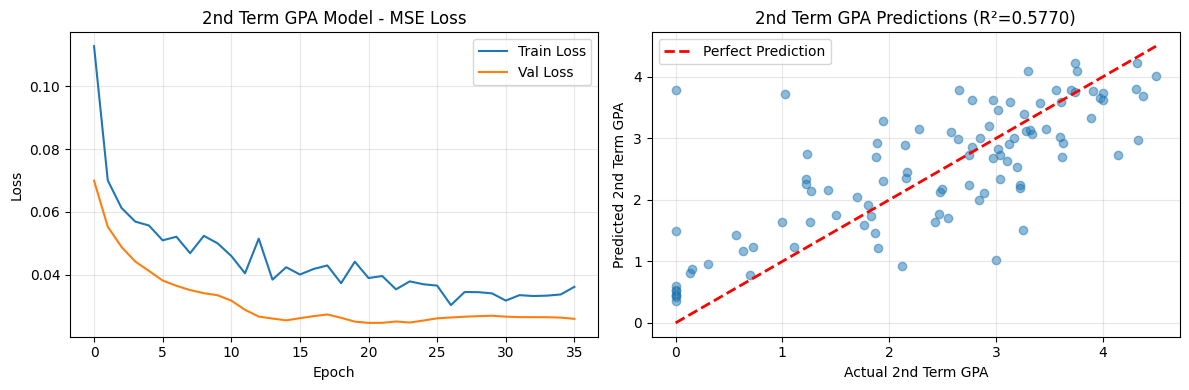


Plot saved: gpa_2nd_model_results.png


In [57]:
# Make predictions (normalized)
y_2nd_pred_norm = gpa_2nd_model.predict(X_test, verbose=0).flatten()
# Denormalize to actual GPA scale
y_2nd_pred = y_2nd_pred_norm * 4.5
y_2nd_test_actual = y_2nd_test * 4.5

# Calculate metrics
gpa2_r2 = r2_score(y_2nd_test_actual, y_2nd_pred)
gpa2_mae = mean_absolute_error(y_2nd_test_actual, y_2nd_pred)
gpa2_rmse = np.sqrt(mean_squared_error(y_2nd_test_actual, y_2nd_pred))
gpa2_mse = mean_squared_error(y_2nd_test_actual, y_2nd_pred)

print("\n" + "="*70)
print("SECOND TERM GPA MODEL - EVALUATION METRICS")
print("="*70)
print(f"\nR² Score: {gpa2_r2:.4f}")
print(f"MAE (Mean Absolute Error): {gpa2_mae:.4f} GPA points")
print(f"RMSE (Root Mean Squared Error): {gpa2_rmse:.4f}")
print(f"MSE (Mean Squared Error): {gpa2_mse:.4f}")

# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training history
axes[0].plot(history_gpa2.history['loss'], label='Train Loss')
axes[0].plot(history_gpa2.history['val_loss'], label='Val Loss')
axes[0].set_title('2nd Term GPA Model - MSE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions vs Actual
axes[1].scatter(y_2nd_test_actual, y_2nd_pred, alpha=0.5)
axes[1].plot([y_2nd_test_actual.min(), y_2nd_test_actual.max()], 
             [y_2nd_test_actual.min(), y_2nd_test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual 2nd Term GPA')
axes[1].set_ylabel('Predicted 2nd Term GPA')
axes[1].set_title(f'2nd Term GPA Predictions (R²={gpa2_r2:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gpa_2nd_model_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nPlot saved: gpa_2nd_model_results.png")

## 10. Summary: All Models Performance

In [58]:
print("\n" + "="*70)
print("FINAL MODEL SUMMARY - ALL NEURAL NETWORK MODELS")
print("="*70)

summary_data = {
    'Model': [
        'Persistence (Classification)',
        'Completion (Classification)',
        '2nd Term GPA (Regression)'
    ],
    'Architecture': [
        '4 layers, 128→64→32→1',
        '4 layers, 96→48→24→1',
        '4 layers, 96→64→32→1 (sigmoid)'
    ],
    'Activation': [
        'ReLU + Sigmoid',
        'ReLU + Sigmoid',
        'ReLU + Sigmoid'
    ],
    'Loss Function': [
        'Binary Crossentropy',
        'Binary Crossentropy',
        'MSE'
    ],
    'Primary Metric': [
        'Accuracy',
        'Accuracy',
        'R²'
    ],
    'Test Performance': [
        f'{pers_accuracy:.4f}',
        f'{comp_accuracy:.4f}',
        f'{gpa2_r2:.4f}'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*70)
print("DETAILED CLASSIFICATION METRICS")
print("="*70)
print(f"\nPersistence Model:")
print(f"  Accuracy: {pers_accuracy:.4f} | Precision: {pers_precision:.4f}")
print(f"  Recall:   {pers_recall:.4f} | F1-Score:  {pers_f1:.4f} | ROC-AUC: {pers_roc_auc:.4f}")

print(f"\nCompletion Model:")
print(f"  Accuracy: {comp_accuracy:.4f} | Precision: {comp_precision:.4f}")
print(f"  Recall:   {comp_recall:.4f} | F1-Score:  {comp_f1:.4f} | ROC-AUC: {comp_roc_auc:.4f}")

print("\n" + "="*70)
print("DETAILED REGRESSION METRICS")
print("="*70)
print(f"\n2nd Term GPA Model:")
print(f"  R² Score: {gpa2_r2:.4f}")
print(f"  MAE:      {gpa2_mae:.4f} GPA points")
print(f"  RMSE:     {gpa2_rmse:.4f}")
print(f"  MSE:      {gpa2_mse:.4f}")


FINAL MODEL SUMMARY - ALL NEURAL NETWORK MODELS

                       Model                   Architecture     Activation       Loss Function Primary Metric Test Performance
Persistence (Classification)          4 layers, 128→64→32→1 ReLU + Sigmoid Binary Crossentropy       Accuracy           0.8384
 Completion (Classification)           4 layers, 96→48→24→1 ReLU + Sigmoid Binary Crossentropy       Accuracy           0.8990
   2nd Term GPA (Regression) 4 layers, 96→64→32→1 (sigmoid) ReLU + Sigmoid                 MSE             R²           0.5770

DETAILED CLASSIFICATION METRICS

Persistence Model:
  Accuracy: 0.8384 | Precision: 0.8495
  Recall:   0.9753 | F1-Score:  0.9080 | ROC-AUC: 0.7668

Completion Model:
  Accuracy: 0.8990 | Precision: 0.9444
  Recall:   0.9444 | F1-Score:  0.9444 | ROC-AUC: 0.8815

DETAILED REGRESSION METRICS

2nd Term GPA Model:
  R² Score: 0.5770
  MAE:      0.6167 GPA points
  RMSE:     0.8276
  MSE:      0.6850


## 11. Save All Models and Scalers

In [59]:
print("="*70)
print("SAVING MODELS AND SCALERS")
print("="*70)

# Save neural network models
persistence_model.save('persistence_model_nn.keras')
print("Saved: persistence_model_nn.keras")

completion_model.save('completion_model_nn.keras')
print("Saved: completion_model_nn.keras")

gpa_2nd_model.save('gpa_2nd_model_nn.keras')
print("Saved: gpa_2nd_model_nn.keras")

# Save scalers
joblib.dump(scaler, 'scaler_main_features.pkl')
print("Saved: scaler_main_features.pkl")

# Save feature information
feature_info = {
    'main_features': list(X.columns),
    'model_info': {
        'persistence': {
            'type': 'Binary Classification NN',
            'accuracy': float(pers_accuracy),
            'precision': float(pers_precision),
            'recall': float(pers_recall),
            'f1': float(pers_f1),
            'roc_auc': float(pers_roc_auc)
        },
        'completion': {
            'type': 'Binary Classification NN',
            'accuracy': float(comp_accuracy),
            'precision': float(comp_precision),
            'recall': float(comp_recall),
            'f1': float(comp_f1),
            'roc_auc': float(comp_roc_auc)
        },
        'gpa_2nd': {
            'type': 'Neural Network Regression',
            'r2_score': float(gpa2_r2),
            'mae': float(gpa2_mae),
            'rmse': float(gpa2_rmse),
            'mse': float(gpa2_mse)
        }
    }
}

joblib.dump(feature_info, 'model_info_nn.pkl')
print("Saved: model_info_nn.pkl")

print("\n" + "="*70)
print("ALL MODELS SAVED SUCCESSFULLY")
print("="*70)


SAVING MODELS AND SCALERS
Saved: persistence_model_nn.keras
Saved: completion_model_nn.keras
Saved: persistence_model_nn.keras
Saved: completion_model_nn.keras
Saved: gpa_2nd_model_nn.keras
Saved: scaler_main_features.pkl
Saved: model_info_nn.pkl

ALL MODELS SAVED SUCCESSFULLY
Saved: gpa_2nd_model_nn.keras
Saved: scaler_main_features.pkl
Saved: model_info_nn.pkl

ALL MODELS SAVED SUCCESSFULLY
